# CROSS VALIDATION : 2 FOLD

<br>

## Introduction

<br>
There are two prominent, special cases of k-fold cross validation: $k = 2$ and $k = N$. In the current notebook we will examine the details and implications of 2-fold cross validation.

<br>
<b>Most literature describes 2-fold cross validation as being equal to the repeated hold-out method (with two iterations). However, this statement would only be true if we perform repeated hold-out using a 50-50 split and sort constraints</b> : in the first iteration the training set consists of the first half of the data in the order the latter are presented and the test set is composed of the second half, in the second iteration we swap the two data sets.

<img src="images/2-fold-summary.png" width="50%" height="50%">

In [1]:
# SETUP : importing

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
#import sklearn.linear_model as lm
import sklearn.neighbors as nbr
from sklearn.model_selection import KFold
import sklearn.metrics as mtr

import utilcompute as uc
from pprint import pprint


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_iris().data, load_iris().target) )
df = pd.DataFrame(data)
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'species']

#print('df.shape[0] : ', df.shape[0])


In [3]:
#df.describe()

In [4]:
# DATA PREPROCESSING : deleting features

to_delete = []
cols = [c for c in df.columns.values.tolist() if (c not in to_delete)]
df = df[cols]

#print('columns : ', df.columns.values.tolist())

In [5]:
target = 'species'
if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [6]:
# DATA PREPROCESSING : features standardization

vif_dict = uc.compute_vif(df = df, features = features)
print('df : ')
print()
pprint(vif_dict)

print()

df_std = uc.standardize(df = df, included = features, excluded = target)

vif_dict = uc.compute_vif(df = df_std, features = features)
print('df_std : ')
print()
pprint(vif_dict)


df : 

{'petal length': 173.96896536339727,
 'petal width': 55.48868864572551,
 'sepal length': 264.7457109493044,
 'sepal width': 97.111605833803296}

df_std : 

{'petal length': 31.397291650719751,
 'petal width': 16.141563956997683,
 'sepal length': 7.1031134428332869,
 'sepal width': 2.0990386257420881}


In [7]:
# DATA PREPROCESSING : vif subset selection [reduces multicollinearity]

VIF = False

if (VIF):
    selected_features = uc.vif_best_subset_selection(
        vif_threshold = 5, 
        df = df_std, 
        features = features, 
        level = len(features), 
        debug = False
    )
    t = uc.concatenate(features, target)
    df_std = df_std[t]
    
    vif_dict = uc.compute_vif(df = df_std, features = selected_features)
    pprint(vif_dict)
else:
    selected_features = features


In [8]:
# DATA PREPROCESSING : final setup

df = df_std
features = selected_features

print(df_std.columns.values)

['petal length' 'petal width' 'sepal length' 'sepal width' 'species']


In [9]:
# GLOBAL PARAMETERS 

n_splits = 2

print('k (# of folds) : ', n_splits)


k (# of folds) :  2


In [10]:
columns = ['iteration', 'err_train', 'err_test']
results_df = pd.DataFrame(data = None, index = None, columns = columns)

kf = KFold(n_splits = n_splits, shuffle = False, random_state = None)    
for k, (train_positions, test_positions) in enumerate(kf.split(X = df[features], y = df[target])) :

    fold_train = df.iloc[train_positions]   
    fold_test = df.iloc[test_positions]  
    
    # if (k == 0):
    #    print('train indices : {0} - {1}'.format(fold_train.index.values[:3], fold_train.index.values[-3:]))
    #    print('test  indices : {0} - {1}'.format(fold_test.index.values[:3], fold_test.index.values[-3:]))
    #    print()

    #model = lm.LogisticRegression()
    model = nbr.KNeighborsClassifier(n_neighbors = 5)
    model.fit(fold_train[features], fold_train[target])

    y_pred_train = model.predict(fold_train[features])
    y_pred_test = model.predict(fold_test[features])
    
    #metrics_train = uc.compute_classification_metrics(y = fold_train[target], y_pred = y_pred_train)
    #metrics_test = uc.compute_classification_metrics(y = fold_test[target], y_pred = y_pred_test)
    
    acc_train = mtr.accuracy_score(y_true = fold_train[target], y_pred = y_pred_train, normalize = True, sample_weight = None)
    acc_test = mtr.accuracy_score(y_true = fold_test[target], y_pred = y_pred_test, normalize = True, sample_weight = None)

    values_dict = {
        'iteration' : k + 1,            
        #'err_train' : 1 - metrics_train['ACCURACY'],
        #'err_test' : 1 - metrics_test['ACCURACY'],
        'err_train' : 1 - acc_train,
        'err_test' : 1 - acc_test,
    }

    results_index = k
    results_df.loc[results_index] = values_dict     

results_df = results_df.astype(dtype = 'float')
#print(results_df)


In [11]:
print()
print('train | err mean : ', results_df['err_train'].mean())
print('train | err std  : ', results_df['err_train'].std())

print()
print('test  | err mean : ', results_df['err_test'].mean())
print('test  | err std  : ', results_df['err_test'].std())



train | err mean :  0.033333333333333326
train | err std  :  0.04714045207910316

test  | err mean :  0.6866666666666668
test  | err std  :  0.02828427124746185


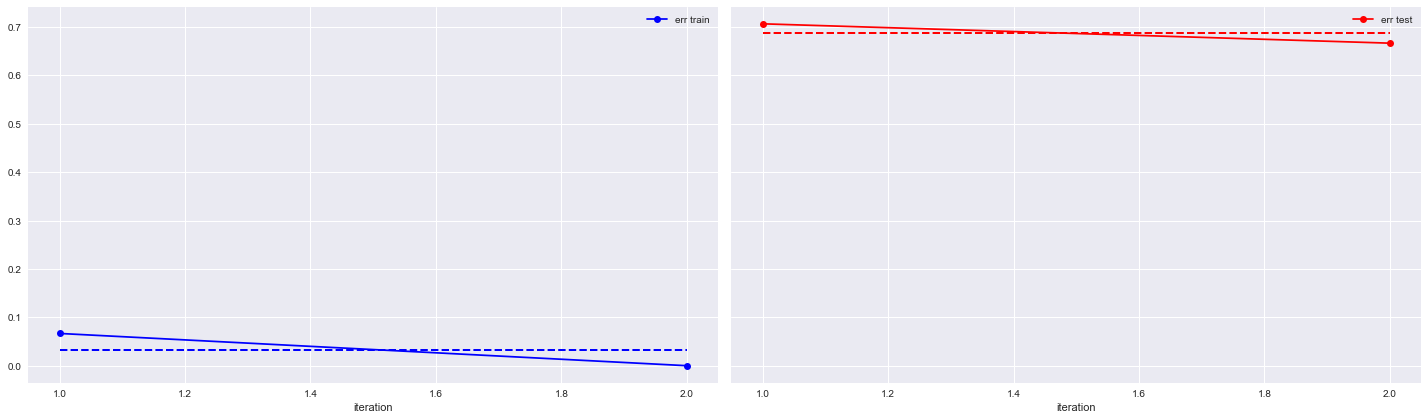

In [12]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 6), sharey = True) 

it_min = results_df['iteration'].min()
it_max = results_df['iteration'].max()

err_train_mean = results_df['err_train'].mean()
err_test_mean = results_df['err_test'].mean()

axs[0].plot(results_df['iteration'], results_df['err_train'], color = 'blue', label = 'err train', marker = 'o')
axs[0].plot( (it_min, it_max), (err_train_mean, err_train_mean), color = 'blue', lw = 2, linestyle = '--')
axs[0].set_xlabel('iteration')
axs[0].legend(loc = 'best')

axs[1].plot(results_df['iteration'], results_df['err_test'], color = 'red', label = 'err test', marker = 'o')
axs[1].plot( (it_min, it_max), (err_test_mean, err_test_mean), color = 'red', lw = 2, linestyle = '--')
axs[1].set_xlabel('iteration')
axs[1].legend(loc = 'best')

plt.tight_layout()
plt.show()


## Considerations

<br>
Choosing a small value of $k$ will lead us towards the extremity of hold-out evaluation; as expected, the distribution of data points which happen to fall in the training or test set has a huge impact on the ability of the model to generalize, and we can observe a very <b>large variance</b>.

<br>
Not only the variance is large but, in contrast to hold-out evaluation, this time <b>also the pessimistic bias is large</b>: such big partitions of the original data set means less training data available for model fitting.


## References

<br>
<ul style="list-style-type:square">
    <li>
        Sebastian Raschka - Model evaluation, model selection, and algorithm selection in machine learning - Part III <br>
        https://sebastianraschka.com/blog/2016/model-evaluation-selection-part3.html
    </li>
</ul>